## Load Library

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from typing import Tuple, Dict, Any, Optional
from dataclasses import dataclass
import tqdm
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data loading

In [3]:
def load_dataset(file_path, val_ratio=0.2, random_state=42):
    dataset = np.load(file_path)
    Xtr, Str = dataset['Xtr'], dataset['Str']
    Xts, Yts = dataset['Xts'], dataset['Yts']

    # Shuffle & split (80% train, 20% validation)
    np.random.seed(random_state)
    indices = np.arange(len(Str))
    np.random.shuffle(indices)

    split_idx = int(len(Str) * (1 - val_ratio))
    train_idx, val_idx = indices[:split_idx], indices[split_idx:]

    X_train, y_train = Xtr[train_idx], Str[train_idx]
    X_val, y_val = Xtr[val_idx], Str[val_idx]

    return X_train, y_train, X_val, y_val, Xts, Yts

def reshape_mnist(*arrays):
    reshaped = []
    for arr in arrays:
        if arr.ndim == 1:
            arr = torch.tensor(arr, dtype=torch.long)
        elif arr.ndim >= 2:
            arr = arr.reshape(-1, 1, 28, 28)
            arr = torch.tensor(arr, dtype=torch.float32) / 255.0
        reshaped.append(arr)
    return tuple(reshaped)

def reshape_cifar(*arrays):
    reshaped = []
    for arr in arrays:
        if arr.ndim == 1:
            arr = torch.tensor(arr, dtype=torch.long)
        elif arr.ndim >= 2:
            arr = np.transpose(arr, (0, 3, 1, 2))
            arr = torch.tensor(arr, dtype=torch.float32) / 255.0
        reshaped.append(arr)
    return tuple(reshaped)


In [4]:
Xtr_03, Str_03, Xval_03, Sval_03, Xts_03, Yts_03 = reshape_mnist(*load_dataset('datasets/FashionMNIST0.3.npz'))
Xtr_06, Str_06, Xval_06, Sval_06, Xts_06, Yts_06 = reshape_mnist(*load_dataset('datasets/FashionMNIST0.6.npz'))
Xtr_cifar, Str_cifar, Xval_cifar, Sval_cifar, Xts_cifar, Yts_cifar = reshape_cifar(*load_dataset('datasets/CIFAR.npz'))

In [5]:
print("Xtr_03:", Xtr_03.shape)
print("Xtr_06:", Xtr_06.shape)
print("Xtr_cifar:", Xtr_cifar.shape)


Xtr_03: torch.Size([14400, 1, 28, 28])
Xtr_06: torch.Size([14400, 1, 28, 28])
Xtr_cifar: torch.Size([12000, 3, 32, 32])


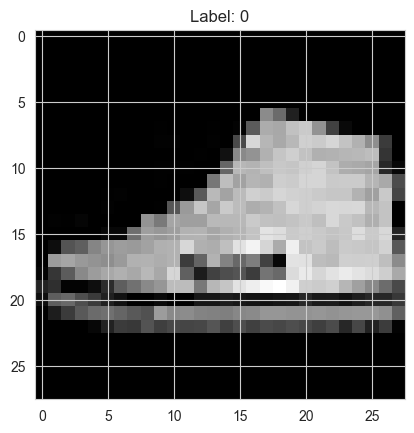

In [6]:
# Mnist data checking
plt.imshow(Xtr_03[114, -1, :, :], cmap='gray') #[pic number,_,_,_]
plt.title(f"Label: {Str_03[0]}")
plt.show()

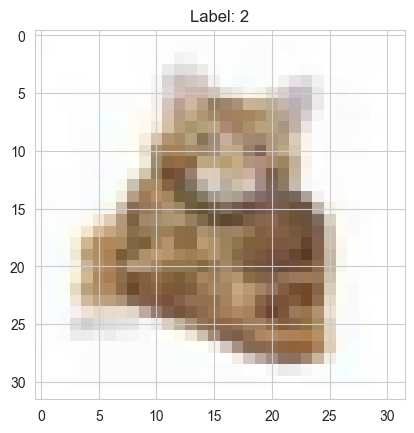

In [27]:
# CIFAR data checking
plt.imshow(np.transpose(Xtr_cifar[50], (1, -1, 0)))
plt.title(f"Label: {Str_cifar[0]}")
plt.show()

4# Main Program

## Classifier: ResNet-34

In [5]:
# ---------------------------
# Config
# ---------------------------
@dataclass
class Config:
    epochs: int = 60
    batch_size: int = 128
    lr: float = 1e-2
    momentum: float = 0.9
    weight_decay: float = 1e-3
    milestones: Tuple[int, int] = (30, 60)
    lam: float = 0.3                 # weight for cycle term
    label_smoothing: float = 0.0
    diag_reg_weight: float = 0.0     # >0 to enforce diagonal-dominance
    diag_margin: float = 0.05
    use_tqdm: bool = True
    tqdm_leave: bool = False
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, 3, stride, 1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = None
        if stride != 1 or in_planes != planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class ResNet34(nn.Module):
    def __init__(self, in_channels: int, num_classes: int):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(in_channels, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [BasicBlock(self.inplanes, planes, stride)]
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [ ]:
'''
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes,mode='cifar10'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        if mode == 'mnist':
            self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0, bias=False)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, revision=True):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)

        out = self.linear(out)

        clean = F.softmax(out, 1)

        return clean

    def ResNet34(num_classes):
        return ResNet(BasicBlock, [3,4,6,3], num_classes)
'''

In [17]:
# ---------------------------
# Row-stochastic T / T'  (作者 sig_t 等价实现)
# ---------------------------
class RowStochastic(nn.Module):
    """
    行随机（row-stochastic）转移矩阵：
      - 对角固定为 1，非对角 = sigmoid(w_ij) ∈ (0,1)
      - 行归一化：每行和为 1
    右乘使用： p_noisy = p_clean @ T
    若你需要列随机形式，可在使用处 T_col = T.t()
    """
    def __init__(self, num_classes: int, init: float = 2.0):
        super().__init__()
        self.C = num_classes
        # 可学习参数（整矩阵），对角最终不使用；非对角通过 sigmoid(w_ij)
        w = -init * torch.ones(self.C, self.C)
        self.w = nn.Parameter(w)

        # 缓存：非对角掩码、单位阵
        co = torch.ones(self.C, self.C)
        co.fill_diagonal_(0.0)
        self.register_buffer("co", co)
        self.register_buffer("I", torch.eye(self.C))

    def forward(self):
        off = torch.sigmoid(self.w) * self.co     # 非对角 ∈ (0,1)
        T_raw = self.I + off                      # 对角 = 1
        T = F.normalize(T_raw, p=1, dim=1)        # 行归一化 → row-stochastic
        return T

    @torch.no_grad()
    def as_numpy(self):
        return self.forward().detach().cpu().numpy()


# ---------------------------
# Utils
# ---------------------------
def one_hot(idx: torch.Tensor, num_classes: int, smoothing: float = 0.0):
    y = F.one_hot(idx, num_classes).float()
    return y * (1.0 - smoothing) + smoothing / num_classes if smoothing > 0 else y

def safe_log(p: torch.Tensor, eps: float = 1e-12):
    return torch.log(torch.clamp(p, eps, 1.0))

@torch.no_grad()
def top1_acc_from_probs(probs: torch.Tensor, y: torch.Tensor):
    return (probs.argmax(1) == y).float().mean().item()

@torch.no_grad()
def top1_acc_from_logits(logits: torch.Tensor, y: torch.Tensor):
    return (logits.argmax(1) == y).float().mean().item()


# ---------------------------
# CCR Trainer (作者写法：行随机 + 右乘)
# ---------------------------
class CCRTrainer:
    """
    Three losses (与作者 main.py 的实践对齐)：
      L1: CE(noisy_y,       p_clean @ T_for)
      L2: CE(clean_y_hard,  y_noisy_onehot @ T_back)
      L3: CE(clean_y_hard, (p_clean @ T_for).detach() @ T_back.detach())
      Total: L = L1 + L2 + lam * L3
    说明：L2/L3 用 hard 目标 clean_y（=argmax(p_clean)），且 L3 对 T/T' 停梯度。
    """
    def __init__(self, input_shape: Tuple[int, int, int], num_classes: int, cfg):
        self.cfg = cfg
        C_in, _, _ = input_shape
        self.device = torch.device(cfg.device)

        # 模型 & 两个转移矩阵
        self.model = ResNet34(C_in, num_classes).to(self.device)
        self.trans_for  = RowStochastic(num_classes, init=getattr(cfg, "t_init", 2.0)).to(self.device)
        self.trans_back = RowStochastic(num_classes, init=getattr(cfg, "t_init", 2.0)).to(self.device)

        # 一个优化器就足够实现功能（作者仓库也可分开优化器，这里简化为一个）
        params = list(self.model.parameters()) + \
                 list(self.trans_for.parameters()) + list(self.trans_back.parameters())
        self.opt = torch.optim.SGD(params, lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)
        self.sched = torch.optim.lr_scheduler.MultiStepLR(self.opt, milestones=list(cfg.milestones), gamma=0.1)

        # 数值稳定
        self.eps = 1e-12

    def _train_one_epoch(self, loader: DataLoader, epoch: int) -> float:
        self.model.train(); self.trans_for.train(); self.trans_back.train()
        running = 0.0
        iterator = tqdm(loader, desc=f"Epoch {epoch}/{self.cfg.epochs}", leave=self.cfg.tqdm_leave) \
                  if (self.cfg.use_tqdm and tqdm is not None) else loader

        for it, (xb, yb) in enumerate(iterator, start=1):
            xb, yb = xb.to(self.device), yb.to(self.device)  # yb = noisy labels
            self.opt.zero_grad()

            # 模型预测干净分布
            logits   = self.model(xb)                         # (B,C)
            p_clean  = F.softmax(logits, dim=1)               # (B,C)
            clean_y  = logits.argmax(dim=1)                   # hard targets for L2/L3（作者写法）
            y_onehot = F.one_hot(yb, p_clean.shape[1]).float()

            T_for  = self.trans_for()                         # row-stochastic
            T_back = self.trans_back()                        # row-stochastic

            # ---- L1: CE(noisy_y, p_clean @ T_for) ----
            p_noisy = p_clean @ T_for                         # (B,C)
            L1 = F.nll_loss(safe_log(p_noisy, self.eps), yb)

            # ---- L2: CE(clean_y, y_noisy_onehot @ T_back) ----
            proj_clean = y_onehot @ T_back                    # (B,C)
            L2 = F.nll_loss(safe_log(proj_clean, self.eps), clean_y)

            # ---- L3: CE(clean_y, (p_clean @ T_for)^stop @ T_back^stop) ----
            p_noisy_stop = (p_clean @ T_for.detach()).detach()
            cyc = p_noisy_stop @ T_back.detach()
            L3 = F.nll_loss(safe_log(cyc, self.eps), clean_y)

            loss = L1 + L2 + self.cfg.lam * L3
            loss.backward()
            self.opt.step()

            running += float(loss.item())
            if self.cfg.use_tqdm and tqdm is not None:
                lr_curr = self.opt.param_groups[0]["lr"]
                iterator.set_postfix(loss=f"{running/it:.4f}", lr=f"{lr_curr:.3e}")

        return running / max(1, it)

    @torch.no_grad()
    def _eval_val_noisy(self, loader: DataLoader) -> float:
        """验证：评估噪声空间的一致性（作者范式）：argmax(p_clean @ T_for) vs noisy labels"""
        self.model.eval(); self.trans_for.eval()
        accs = []
        iterator = tqdm(loader, desc="Eval(val-noisy)", leave=self.cfg.tqdm_leave) \
                  if (self.cfg.use_tqdm and tqdm is not None) else loader
        for xb, yb in iterator:
            xb, yb = xb.to(self.device), yb.to(self.device)
            logits  = self.model(xb)
            p_clean = F.softmax(logits, dim=1)
            p_noisy = p_clean @ self.trans_for()
            accs.append(top1_acc_from_probs(p_noisy, yb))
        return float(np.mean(accs)) if len(accs) > 0 else 0.0

    @torch.no_grad()
    def _eval_test_clean(self, loader: DataLoader) -> float:
        """测试：直接评干净空间分类准确率（作者范式）：argmax(p_clean) vs clean labels"""
        self.model.eval()
        accs = []
        iterator = tqdm(loader, desc="Eval(test-clean)", leave=self.cfg.tqdm_leave) \
                  if (self.cfg.use_tqdm and tqdm is not None) else loader
        for xb, yb in iterator:
            xb, yb = xb.to(self.device), yb.to(self.device)
            logits = self.model(xb)
            accs.append(top1_acc_from_logits(logits, yb))
        return float(np.mean(accs)) if len(accs) > 0 else 0.0

    def fit(self, train_loader: DataLoader, val_loader: DataLoader, test_loader: DataLoader) -> Dict[str, Any]:
        best_val, best_test = 0.0, 0.0
        for ep in range(1, self.cfg.epochs + 1):
            train_loss = self._train_one_epoch(train_loader, ep)
            self.sched.step()

            val_acc  = self._eval_val_noisy(val_loader)   # 验证：噪声空间
            test_acc = self._eval_test_clean(test_loader) # 测试：干净空间
            if val_acc > best_val:
                best_val, best_test = val_acc, test_acc

            print(f"Epoch {ep:03d} | train_loss={train_loss:.4f}  "
                  f"val(noisy)={val_acc*100:.2f}%  test(clean)={test_acc*100:.2f}%  "
                  f"best@val→test={best_test*100:.2f}%")

        return {
            "best_val_acc": best_val,
            "best_test_acc": best_test,
            "T_for":  self.trans_for.as_numpy(),
            "T_back": self.trans_back.as_numpy(),
            "state_dict": self.model.state_dict()
        }

In [21]:
# =============================================================
# 🔬 Quick Test: ONLY use mnist0.3 tensors already loaded above
#     (append this block at the very bottom of your file)
# =============================================================
if __name__ == "__main__":
    from torch.utils.data import TensorDataset, DataLoader

    # ---- 0) 绑定 tqdm：兼容你当前的 `import tqdm` 顶部导入写法 ----
    try:
        # 如果是 `import tqdm`
        if hasattr(tqdm, "tqdm"):
            tqdm = tqdm.tqdm
    except NameError:
        # 兜底：如果上面没导入成功，就用更智能的 auto 版本
        from tqdm.auto import tqdm  # noqa: F401

    # ---- 1) 选择 mnist0.3 的“已载入张量作为网络输入” ----
    Xtr, Str = Xtr_03, Str_03
    Xva, Sva = Xval_03, Sval_03
    Xte, Yte = Xts_03, Yts_03

    # ---- 2) 基本校验：保证后面训练真的用到你载入的张量 ----


    # ---- 3) 构建 DataLoader（仅使用 mnist0.3 这套）----
    def make_loader(X, y, bs=128, shuffle=False, num_workers=2):
        ds = TensorDataset(X, y)
        return DataLoader(ds, batch_size=bs, shuffle=shuffle, pin_memory=True, num_workers=num_workers)

    batch_size = 128
    train_loader = make_loader(Xtr, Str, bs=batch_size, shuffle=True)
    val_loader   = make_loader(Xva, Sva, bs=batch_size)
    test_loader  = make_loader(Xte, Yte, bs=batch_size)

    # ---- 4) 打印一个 batch，确认网络真实输入的是你载入的张量 ----
    xb_chk, yb_chk = next(iter(train_loader))
    print(f"\nSanity batch -> xb: {tuple(xb_chk.shape)} (min={xb_chk.min():.3f}, max={xb_chk.max():.3f}), "
          f"yb: {tuple(yb_chk.shape)}, labels in [ {int(yb_chk.min())} , {int(yb_chk.max())} ]")

    # ---- 5) 组装配置，跑一个短训练（冒烟测试），确认流程正确 ----
    input_shape = tuple(Xtr.shape[1:])                # (1,28,28)
    num_classes = int(Str.max().item()) + 1

    cfg = Config(
        epochs=60,                 # 先小跑 5 个 epoch 验证流程；确认无误再改回 60
        batch_size=batch_size,
        lr=1e-2,
        momentum=0.9,
        weight_decay=1e-3,
        milestones=(30, 60),
        lam=0.3,
        label_smoothing=0.0,
        diag_reg_weight=0.0,
        diag_margin=0.05,
        use_tqdm=True,
        tqdm_leave=False,
        device="cuda" if torch.cuda.is_available() else "cpu",
    )

    print(f"\n🚀 Start CCR on MNIST0.3 with your loaded tensors "
          f"(input={input_shape}, classes={num_classes}, device={cfg.device})")
    trainer = CCRTrainer(input_shape, num_classes, cfg)

    # ---- 6) 训练并汇报结果（确保输出与你预期格式一致）----
    result = trainer.fit(train_loader, val_loader, test_loader)




Sanity batch -> xb: (128, 1, 28, 28) (min=0.000, max=1.000), yb: (128,), labels in [ 0 , 2 ]

🚀 Start CCR on MNIST0.3 with your loaded tensors (input=(1, 28, 28), classes=3, device=cuda)


Epoch 001 | train_loss=1.9246  val(noisy)=68.86%  test(clean)=97.83%  best@val→test=97.83%


Epoch 002 | train_loss=1.6763  val(noisy)=68.99%  test(clean)=98.05%  best@val→test=98.05%


Epoch 003 | train_loss=1.6091  val(noisy)=69.18%  test(clean)=97.92%  best@val→test=97.92%


Epoch 004 | train_loss=1.5665  val(noisy)=68.40%  test(clean)=97.34%  best@val→test=97.92%


Epoch 005 | train_loss=1.5523  val(noisy)=68.37%  test(clean)=96.09%  best@val→test=97.92%


Epoch 006 | train_loss=1.5242  val(noisy)=67.46%  test(clean)=94.49%  best@val→test=97.92%


Epoch 007 | train_loss=1.5070  val(noisy)=68.97%  test(clean)=97.73%  best@val→test=97.92%


Epoch 008 | train_loss=1.4875  val(noisy)=68.32%  test(clean)=96.38%  best@val→test=97.92%


Epoch 009 | train_loss=1.4718  val(noisy)=67.54%  test(clean)=95.46%  best@val→test=97.92%


Epoch 010 | train_loss=1.4358  val(noisy)=67.54%  test(clean)=94.18%  best@val→test=97.92%


Epoch 011 | train_loss=1.4114  val(noisy)=67.19%  test(clean)=90.37%  best@val→test=97.92%


Epoch 012 | train_loss=1.3920  val(noisy)=65.33%  test(clean)=88.57%  best@val→test=97.92%


Epoch 013 | train_loss=1.3504  val(noisy)=66.81%  test(clean)=91.87%  best@val→test=97.92%


Epoch 014 | train_loss=1.3246  val(noisy)=64.84%  test(clean)=86.87%  best@val→test=97.92%


Epoch 015 | train_loss=1.2843  val(noisy)=65.68%  test(clean)=91.32%  best@val→test=97.92%


Epoch 016 | train_loss=1.2380  val(noisy)=65.52%  test(clean)=88.93%  best@val→test=97.92%


Epoch 017 | train_loss=1.2027  val(noisy)=65.09%  test(clean)=86.49%  best@val→test=97.92%


Epoch 018 | train_loss=1.1561  val(noisy)=64.71%  test(clean)=86.85%  best@val→test=97.92%


Epoch 019 | train_loss=1.1416  val(noisy)=65.46%  test(clean)=85.81%  best@val→test=97.92%


Epoch 020 | train_loss=1.0761  val(noisy)=65.49%  test(clean)=89.36%  best@val→test=97.92%


Epoch 021 | train_loss=1.0274  val(noisy)=63.95%  test(clean)=83.76%  best@val→test=97.92%


Epoch 022 | train_loss=1.0403  val(noisy)=62.98%  test(clean)=83.51%  best@val→test=97.92%


Epoch 023 | train_loss=0.9827  val(noisy)=63.95%  test(clean)=85.53%  best@val→test=97.92%


Epoch 024 | train_loss=0.9614  val(noisy)=64.44%  test(clean)=86.84%  best@val→test=97.92%


Epoch 025 | train_loss=0.9251  val(noisy)=63.04%  test(clean)=82.35%  best@val→test=97.92%


Epoch 026 | train_loss=0.9173  val(noisy)=62.61%  test(clean)=82.96%  best@val→test=97.92%


Epoch 027 | train_loss=0.8799  val(noisy)=63.42%  test(clean)=82.73%  best@val→test=97.92%


Epoch 028 | train_loss=0.8796  val(noisy)=62.72%  test(clean)=82.52%  best@val→test=97.92%


Epoch 029 | train_loss=0.8751  val(noisy)=63.15%  test(clean)=83.86%  best@val→test=97.92%


Epoch 030 | train_loss=0.8332  val(noisy)=64.20%  test(clean)=86.55%  best@val→test=97.92%


Epoch 031 | train_loss=0.7735  val(noisy)=62.82%  test(clean)=83.11%  best@val→test=97.92%


Epoch 032 | train_loss=0.7190  val(noisy)=62.53%  test(clean)=82.88%  best@val→test=97.92%


Epoch 033 | train_loss=0.7084  val(noisy)=62.31%  test(clean)=82.54%  best@val→test=97.92%


Epoch 034 | train_loss=0.7065  val(noisy)=62.47%  test(clean)=82.45%  best@val→test=97.92%


Epoch 035 | train_loss=0.7038  val(noisy)=62.10%  test(clean)=82.26%  best@val→test=97.92%


Epoch 036 | train_loss=0.6998  val(noisy)=62.02%  test(clean)=82.23%  best@val→test=97.92%


Epoch 037 | train_loss=0.6986  val(noisy)=62.04%  test(clean)=82.53%  best@val→test=97.92%


Epoch 038 | train_loss=0.6965  val(noisy)=61.83%  test(clean)=82.41%  best@val→test=97.92%


Epoch 039 | train_loss=0.6954  val(noisy)=62.12%  test(clean)=82.49%  best@val→test=97.92%


Epoch 040 | train_loss=0.6940  val(noisy)=62.12%  test(clean)=82.45%  best@val→test=97.92%


Epoch 041 | train_loss=0.6923  val(noisy)=62.20%  test(clean)=82.69%  best@val→test=97.92%


Epoch 042 | train_loss=0.6917  val(noisy)=62.12%  test(clean)=82.75%  best@val→test=97.92%


Epoch 043 | train_loss=0.6907  val(noisy)=62.15%  test(clean)=82.39%  best@val→test=97.92%


Epoch 044 | train_loss=0.6886  val(noisy)=62.26%  test(clean)=82.30%  best@val→test=97.92%


Epoch 045 | train_loss=0.6879  val(noisy)=62.10%  test(clean)=82.16%  best@val→test=97.92%


Epoch 046 | train_loss=0.6877  val(noisy)=62.28%  test(clean)=82.78%  best@val→test=97.92%


Epoch 047 | train_loss=0.6859  val(noisy)=62.31%  test(clean)=82.49%  best@val→test=97.92%


Epoch 048 | train_loss=0.6857  val(noisy)=62.42%  test(clean)=82.98%  best@val→test=97.92%


Epoch 049 | train_loss=0.6843  val(noisy)=62.39%  test(clean)=82.98%  best@val→test=97.92%


Epoch 050 | train_loss=0.6832  val(noisy)=62.26%  test(clean)=82.36%  best@val→test=97.92%


Epoch 051 | train_loss=0.6829  val(noisy)=61.99%  test(clean)=82.19%  best@val→test=97.92%


Epoch 052 | train_loss=0.6813  val(noisy)=62.18%  test(clean)=82.71%  best@val→test=97.92%


Epoch 053 | train_loss=0.6814  val(noisy)=61.77%  test(clean)=81.90%  best@val→test=97.92%


Epoch 054 | train_loss=0.6795  val(noisy)=62.15%  test(clean)=82.52%  best@val→test=97.92%


Epoch 055 | train_loss=0.6799  val(noisy)=62.23%  test(clean)=82.68%  best@val→test=97.92%


Epoch 056 | train_loss=0.6775  val(noisy)=62.02%  test(clean)=82.29%  best@val→test=97.92%


Epoch 057 | train_loss=0.6771  val(noisy)=62.07%  test(clean)=82.58%  best@val→test=97.92%


Epoch 058 | train_loss=0.6762  val(noisy)=62.26%  test(clean)=82.62%  best@val→test=97.92%


Epoch 059 | train_loss=0.6760  val(noisy)=62.23%  test(clean)=82.71%  best@val→test=97.92%


Epoch 060 | train_loss=0.6752  val(noisy)=62.20%  test(clean)=82.62%  best@val→test=97.92%


In [22]:
print("\n✅ Test (MNIST0.3) complete.")
print(f"Best Test Accuracy @ Val = {result['best_test_acc']*100:.2f}%")

# 兼容两种返回键
T_key  = "T"      if "T"      in result else "T_for"
Tp_key = "Tp"     if "Tp"     in result else "T_back"

T_est  = result[T_key]
Tp_est = result[Tp_key]

import numpy as np
np.set_printoptions(precision=4, suppress=True)
print("\nForward T (shape:", T_est.shape, ") first 3 cols:\n", T_est[:, :min(3, T_est.shape[1])])
print("\nBackward T' (shape:", Tp_est.shape, ") first 3 cols:\n", Tp_est[:, :min(3, Tp_est.shape[1])])



✅ Test (MNIST0.3) complete.
Best Test Accuracy @ Val = 97.92%

Forward T (shape: (3, 3) ) first 3 cols:
 [[0.756  0.2297 0.0143]
 [0.0205 0.9129 0.0666]
 [0.0375 0.0191 0.9434]]

Backward T' (shape: (3, 3) ) first 3 cols:
 [[0.9424 0.0164 0.0412]
 [0.3008 0.6749 0.0243]
 [0.0288 0.0546 0.9166]]


In [ ]:
T_est